<a href="https://colab.research.google.com/github/bustyAI/stroke-predictions/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns

In [3]:
file_name = "/content/drive/MyDrive/Coding Dojo/Project 2/Data/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_name)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 1. EDA


In [4]:
# getting info on our data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
# checking if we have duplicate rows
df.duplicated().sum()

0

In [6]:
# I am going to drop the "id" column as it is just a unique identifier
df = df.drop(columns="id")

# checking if column got dropped
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# renaming "Residence_type" column just for consistency 
df = df.rename(columns={"Residence_type": "residence_type"})

# checking to see if our column got renamed
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [8]:
# checking how much null values we have in bmi
df["bmi"].isnull().sum()

201

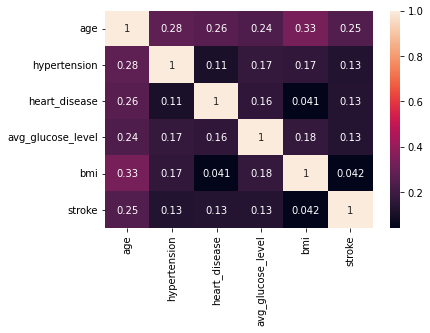

In [9]:
# making a correlation heat map of our data
corr = df.corr()

sns.heatmap(corr, data=df, annot=True)

- Decided to create a heat map to see if their was any correlation between bmi and our other features so I could then explore the data and gain insight to see what I should fill the null values in our bmi with.

- Since there isn't any strong correlation between bmi and our other features, and the way to calculate bmi is by a persons height and weight which our data set does not have. I have decided to drop the 201 columns since there is no way to accurately fill in those values with the data we currently have. We would only be dropping roughly 3.9% of our data, less than 5%.

- Also no strong positive or negative corelations between our features.

In [10]:
# dropping our rows will null values
df = df.dropna()

# checking to see if our rows got dropped
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
# checking how many rows we ended up with
df.shape

(4909, 11)

In [12]:
# saving our dtypes
df_dtypes = df.dtypes
df_dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [13]:
# saving our object dtypes
str_cols = df_dtypes[df_dtypes == "object"].index
str_cols

Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')

In [14]:
# looping through our values to see if their are any syntax errors or inconsistencies
for col in str_cols:
  print(f"Column: {col}")
  print(df[col].value_counts())
  print("\n\n")

Column: gender
Female    2897
Male      2011
Other        1
Name: gender, dtype: int64



Column: ever_married
Yes    3204
No     1705
Name: ever_married, dtype: int64



Column: work_type
Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64



Column: residence_type
Urban    2490
Rural    2419
Name: residence_type, dtype: int64



Column: smoking_status
never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64





- No syntax errors or inconsistencies

In [ ]:
# checking to see if there are any inconsistent or impossible values in our data
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- Definitely have some outliers, but the outliers are possible. We do have some babies and kids in our data, although not common strokes can happen in younger people so these are also valid. For bmi we also have some very high values but they are not impossible. To conclude, there are outliers but all values are possible.